In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import pandas as pd

In [2]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()
1

1

In [20]:
dataset = 'airquality' #choose 'healthcare' or 'airquality'
datafolder = 'pm25_outsample_20250423_163458_verify_May'#'pretrained' # set the folder name
nsample = 10 # number of generated sample

path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk' 
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load( f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

if dataset == 'airquality':
    path = 'data/pm25/pm25_meanstd.pk'
    with open(path, 'rb') as f:
        train_mean,train_std = pickle.load(f)
    train_std_cuda = torch.from_numpy(train_std).cuda()
    train_mean_cuda = torch.from_numpy(train_mean).cuda()
    all_target_np=(all_target_np*train_std+train_mean)
    samples=(samples*train_std_cuda+train_mean_cuda)

In [21]:

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

In [22]:
all_target_np.shape

(21, 36, 36)

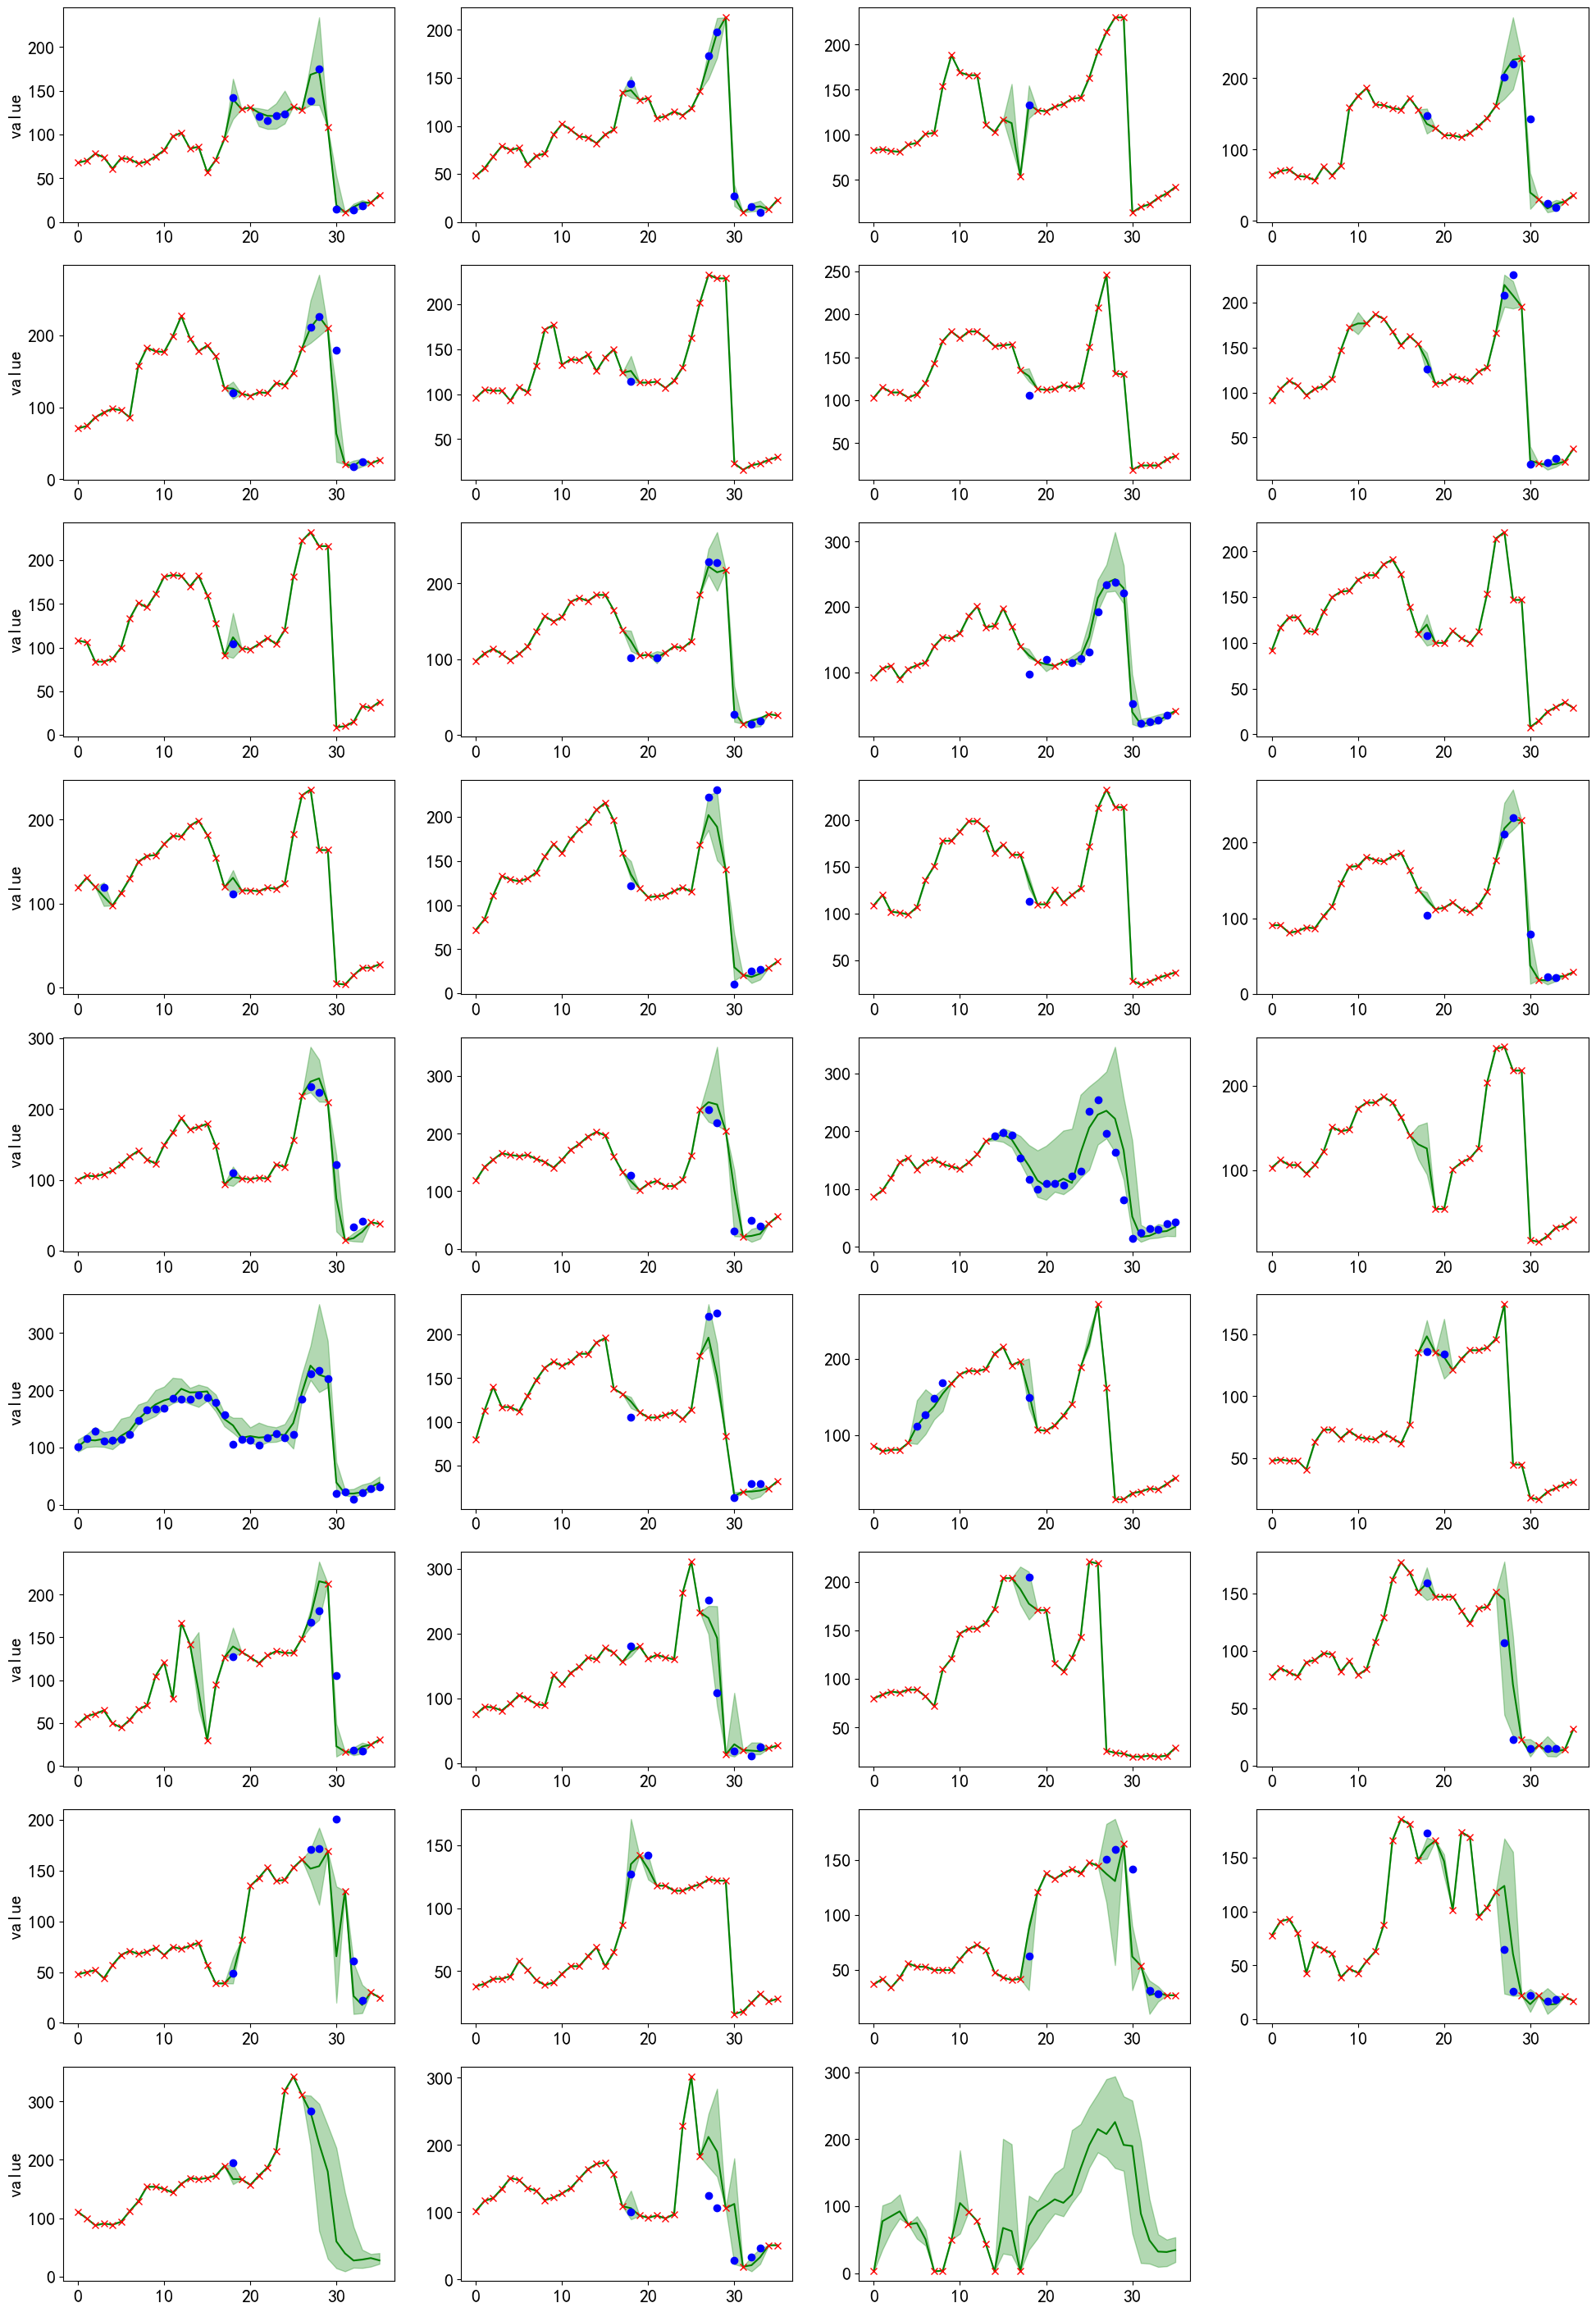

In [13]:
###healthcare###
dataind = 10 #change to visualize a different time-series sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')


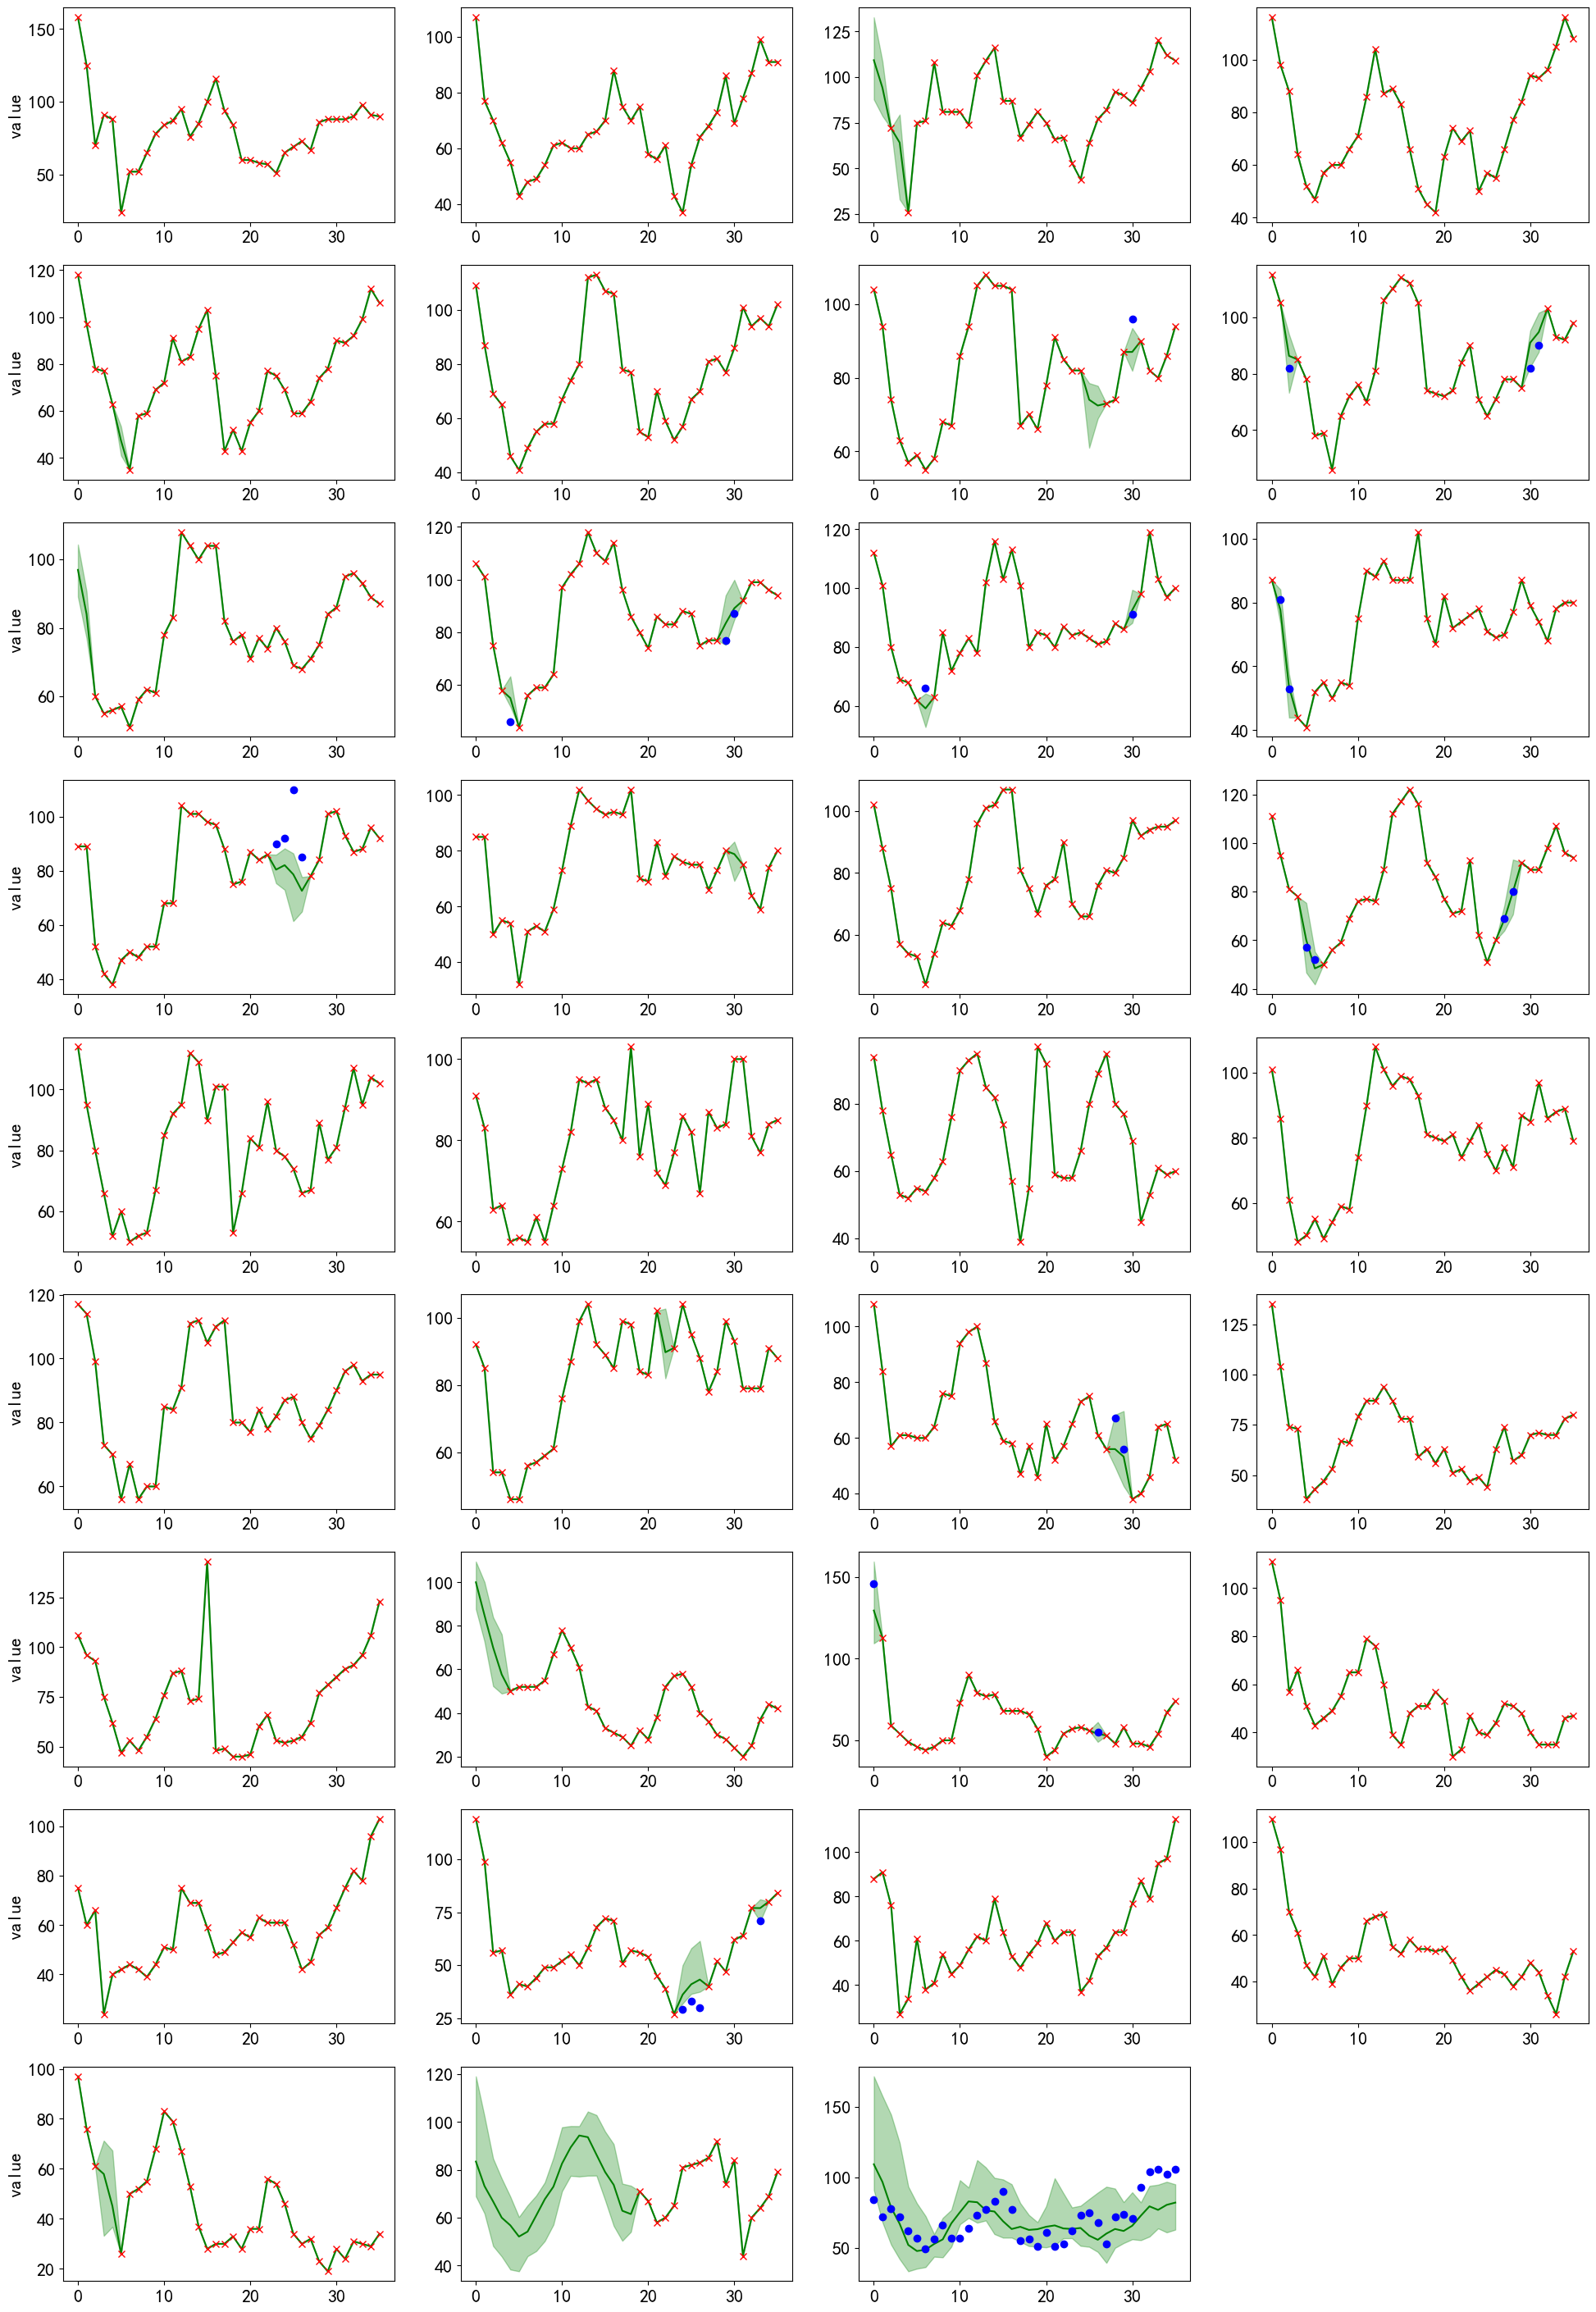

In [23]:
###airquality###
dataind = 15 #change to visualize a different sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')
plt.savefig('prediction_540_576.png')

In [9]:
k=0
list_mae = []
for k in range(36):
    mask = all_evalpoint_np[:,:,k]!=0
    MAE = np.abs(all_target_np[:,:,k][mask] - quantiles_imp[2][:,:,k][mask]).mean()
    print(f'{k}: {(MAE-train_mean[k])/train_std[k]}')
    # su += (MAE-train_mean[k])/train_std[k]
    list_mae.append(MAE)

0: -0.9708515388008
1: -0.9266284832481367
2: -1.0468850675462649
3: -0.9809296303844177
4: -0.9732175713585951
5: -0.9784220942778127
6: -0.9910002618901997
7: -1.002919229958765
8: -1.0033761752258146
9: -1.024810538992383
10: -1.0734020230127665
11: -0.9704889273652348
12: -0.9668781812151268
13: -0.955423417272316
14: -1.0459464347639214
15: -1.0272835759554466
16: -0.9710324035526811
17: -0.9776527927912301
18: -0.9873216494946856
19: -1.0365733508552284
20: -1.0437240239265109
21: -0.9782579678297342
22: -0.9435593906685
23: -0.9043459625458439
24: -0.9337847474133464
25: -0.9256402779325826
26: -0.9864154504364607
27: -0.8511711355469124
28: -0.8681326354143457
29: -0.8747364626835231
30: -0.7993791365965586
31: -0.8088978496649268
32: -0.9535760878334344
33: -0.9458426164641197
34: -0.9139604260948937
35: -0.9354369309555585


In [16]:
list_mae

[10.655795886697364,
 8.79950784004657,
 7.495222031394381,
 9.319061799148068,
 10.58674288957439,
 9.676087647412192,
 10.5139094292276,
 9.068502235236318,
 7.27974582543835,
 7.303603834605026,
 7.454352213198021,
 7.6389352463966675,
 9.293159274284031,
 8.348038852846031,
 6.665151195608591,
 7.217018060101503,
 10.638605351893553,
 13.545525614138969,
 11.15503372408455,
 6.892205045754247,
 7.484640055807339,
 9.014871114516083,
 11.863336886679342,
 8.616372405398494,
 9.611180807670241,
 12.491256487526831,
 6.016985184621416,
 10.271770962594651,
 12.185954100184782,
 6.550192126291129,
 13.390754057957102,
 10.400314092154744,
 12.00083256885647,
 16.106978298737225,
 18.877510825610816,
 20.12466976744926]

array([14,  7,  5, 12,  1,  8,  9,  0, 20, 10, 11, 21,  6,  2, 23, 29, 24,
       26, 30, 13, 19, 15, 22, 27, 28,  3, 31, 17, 16,  4, 18, 32, 25, 34,
       33, 35])

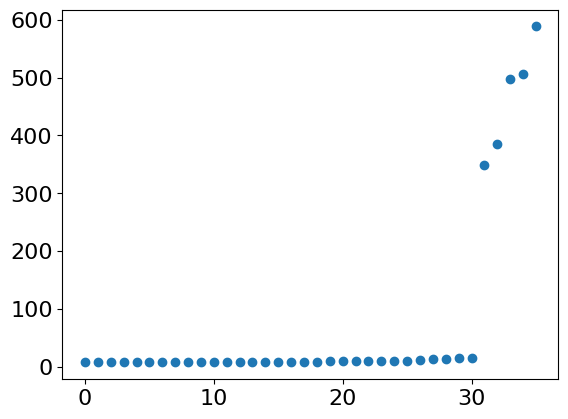

In [9]:
plt.plot(np.sort(list_mae), 'o')

a = np.argsort(list_mae)
a

In [10]:
list_mae

[8.242469047902699,
 8.133379112332651,
 8.464400254681273,
 10.077662095576605,
 14.647068532817277,
 7.851774499877803,
 8.451070573934315,
 7.619332900236367,
 8.155668470048711,
 8.217544136966135,
 8.340578813260114,
 8.370437236913338,
 7.987205142217792,
 9.20451395093442,
 7.362890740446673,
 9.31587175829545,
 13.145344661169736,
 12.950754057159267,
 14.902695258388512,
 9.221970554602981,
 8.321456062081296,
 8.421412673791707,
 9.512358046409702,
 8.504469645390314,
 8.568092000629582,
 384.8271747239043,
 8.59530319483488,
 9.558017255685316,
 9.637369093303835,
 8.561867416404649,
 8.773055038202285,
 11.579599011376395,
 349.55444476085137,
 506.25904534173463,
 498.2217284884181,
 588.4699230687168]

In [11]:
np.random.choice(36, 10, replace=False)

array([26,  7, 27,  6, 23,  5, 16, 19, 17,  0])

In [12]:
mm = np.random.choice(36, 10, replace=False)
all_evalpoint_np = np.zeros([82,36,36])
all_evalpoint_np[:,mm,:] = 1

8.081127978930624


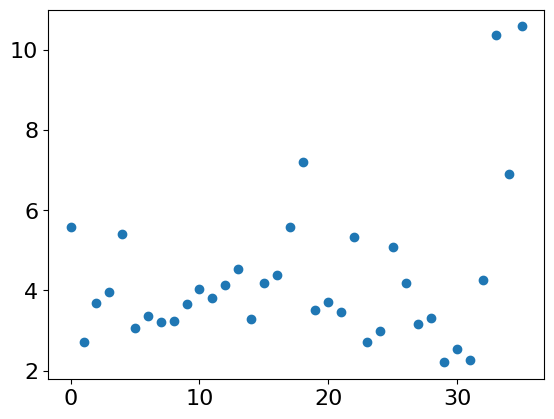

In [21]:
ddd = samples.cpu().numpy().transpose(1,0,2,3)*all_evalpoint_np
ddd[0,5,0,:] = 170



print(np.std(ddd,axis=0)[5,20,0])
np.std(ddd[:,5,20,0])


# ddd.shape
plt.plot(np.mean(np.std(ddd, axis=0), axis=1)[5],'o')

In [22]:
np.mean(np.std(ddd, axis=0))

1.8198205178264326

In [23]:
std_1 = np.mean(np.std(ddd[:,:,:,[2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]], axis=0))
std_2 = np.mean(np.std(ddd[:,:,:,[0,  1, 22, 23, 24, 26, 27, 28, 29, 30, 31]], axis=0))
std_3 = np.mean(np.std(ddd[:,:,:,[25, 32, 33, 34, 35]], axis=0))

print(std_1, std_2, std_3)

1.657453392772185 1.6553828930142558 2.831051792630213


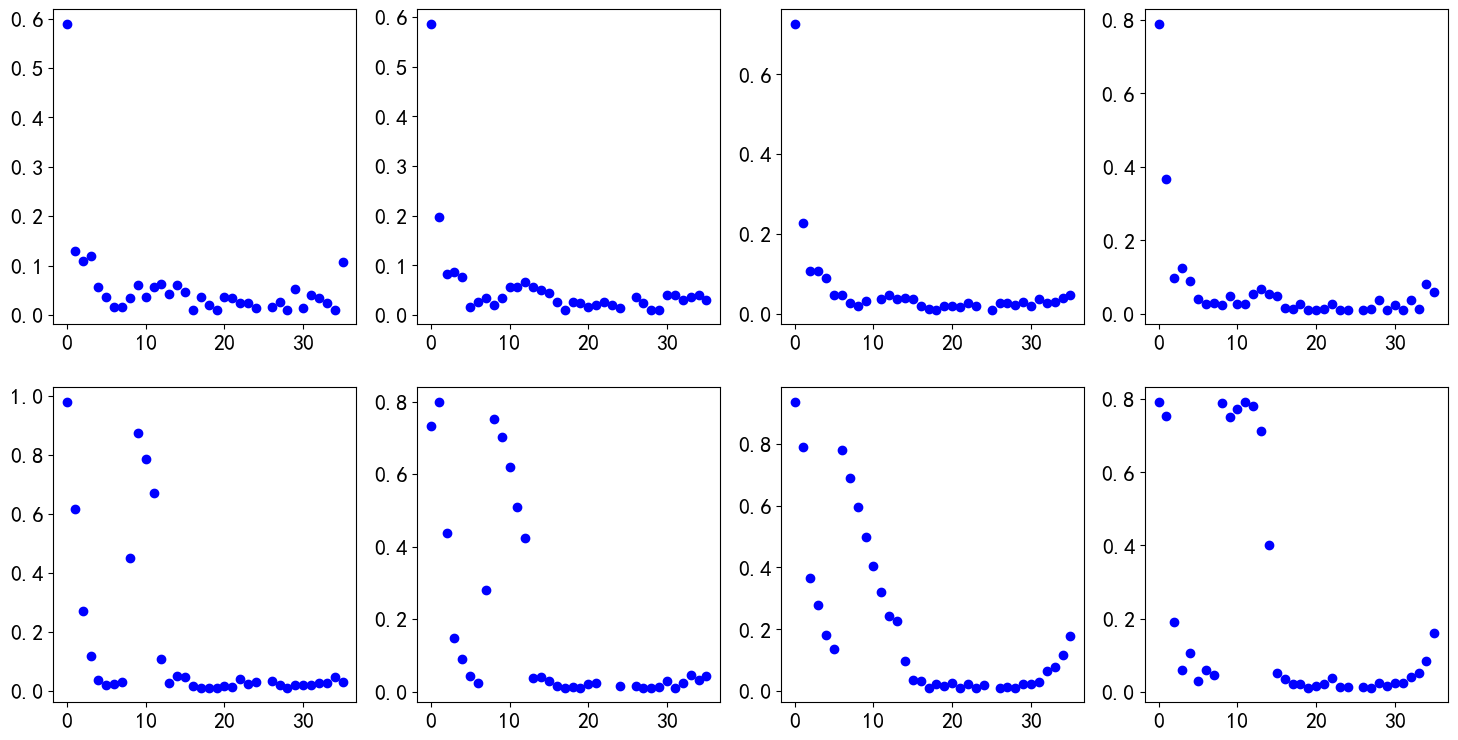

In [34]:

dataind = 5

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(18.0, 9.0))
axes = axes.flatten()
for i, k in enumerate([0,1,2,3,25,32,33,34]):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    
    axes[i].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[i].plot(df2.x,df2.val, color = 'b',marker = 'o', linestyle='None')

# fig.savefig('fig.png')